**Import required libraries**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.applications import VGG16
import numpy as np
import os
import cv2

**Check TensorFlow**

In [ ]:
print(tf.__version__)

2.19.0


**STEP 2: Define dataset paths**

In [ ]:
BASE_PATH = "/content/drive/MyDrive/Dataset"

TRAIN_2D = f"{BASE_PATH}/train/2d"
VAL_2D   = f"{BASE_PATH}/val/2d"
TEST_2D  = f"{BASE_PATH}/test/2d"

TRAIN_3D = f"{BASE_PATH}/train/3d"
VAL_3D   = f"{BASE_PATH}/val/3d"
TEST_3D  = f"{BASE_PATH}/test/3d"

**STEP 3: Data loading functions**


1.   3D voxel loader

In [ ]:
def load_3d_data(base_path):
    X, y = [], []

    for label, cls in enumerate(["nonbinding", "binding"]):
        folder = os.path.join(base_path, cls)
        for file in os.listdir(folder):
            if file.endswith(".npy"):
                grid = np.load(os.path.join(folder, file))
                X.append(grid)
                y.append(label)

    return np.array(X), np.array(y)


2.   2D image loader (VGG16 input)


In [ ]:
def load_2d_data(base_path):
    X, y = [], []

    for label, cls in enumerate(["nonbinding", "binding"]):
        folder = os.path.join(base_path, cls)
        for file in os.listdir(folder):
            if file.endswith(".png"):
                img = cv2.imread(os.path.join(folder, file))
                img = cv2.resize(img, (224, 224))
                img = img / 255.0
                X.append(img)
                y.append(label)

    return np.array(X), np.array(y)

**STEP 4: Load train / val / test data**

In [ ]:
X3D_train, y_train = load_3d_data(TRAIN_3D)
X3D_val,   y_val   = load_3d_data(VAL_3D)
X3D_test,  y_test  = load_3d_data(TEST_3D)

X2D_train, _ = load_2d_data(TRAIN_2D)
X2D_val,   _ = load_2d_data(VAL_2D)
X2D_test,  _ = load_2d_data(TEST_2D)

# Add channel dimension to 3D data
X3D_train = X3D_train[..., np.newaxis]
X3D_val   = X3D_val[..., np.newaxis]
X3D_test  = X3D_test[..., np.newaxis]

print(X3D_train.shape, X2D_train.shape)


(82, 32, 32, 32, 1) (82, 224, 224, 3)


**STEP 5: Build the 3D-CNN branch**

In [ ]:
def build_3d_cnn():
    input_3d = Input(shape=(32, 32, 32, 1))

    x = layers.Conv3D(32, 3, activation='relu')(input_3d)
    x = layers.MaxPooling3D(2)(x)

    x = layers.Conv3D(64, 3, activation='relu')(x)
    x = layers.MaxPooling3D(2)(x)

    x = layers.Conv3D(128, 3, activation='relu')(x)
    x = layers.GlobalAveragePooling3D()(x)

    x = layers.Dense(256, activation='relu')(x)

    return models.Model(input_3d, x)

**STEP 6: Build the VGG16 branch**

In [ ]:
def build_vgg16():
    base = VGG16(weights='imagenet', include_top=False,
                 input_shape=(224, 224, 3))

    for layer in base.layers:
        layer.trainable = False

    x = base.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)

    return models.Model(base.input, x)

**STEP 7: Fuse both models (LATE FUSION)**

In [ ]:
cnn3d = build_3d_cnn()
vgg = build_vgg16()

combined = layers.concatenate([cnn3d.output, vgg.output])

x = layers.Dense(256, activation='relu')(combined)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs=[cnn3d.input, vgg.input],
                     outputs=output)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


**STEP 8: Compile the model**

In [ ]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 224, 224,  │      1,792 │ input_layer_1[0]… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 224, 224,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 112, 112,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 112, 112,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 112, 112,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 56, 56,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 56, 56,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 56, 56,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 56, 56,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 28, 28,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 28, 28,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 28, 28,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer         │ (None, 32, 32,    │          0 │ -                 │
│ (InputLayer)        │ 32, 1)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 28, 28,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d (Conv3D)     │ (None, 30, 30,    │        896 │ input_layer[0][0] │
│                     │ 30, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 14, 14,    │          0 │ block4_conv3[0][

 Total params: 15,288,193 (58.32 MB)

 Trainable params: 573,505 (2.19 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

**STEP 9: Train the hybrid model**

In [ ]:
history = model.fit(
    [X3D_train, X2D_train], y_train,
    validation_data=([X3D_val, X2D_val], y_val),
    epochs=20,
    batch_size=4
)

Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 66s 3s/step - accuracy: 0.6733 - loss: 0.6953 - val_accuracy: 0.6111 - val_loss: 0.6632
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.5316 - loss: 0.8129 - val_accuracy: 0.6111 - val_loss: 0.6628
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - accuracy: 0.6438 - loss: 0.6803 - val_accuracy: 0.6111 - val_loss: 0.6216
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.6270 - loss: 0.5930 - val_accuracy: 0.6111 - val_loss: 0.6606
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 62s 3s/step - accuracy: 0.6186 - loss: 0.5839 - val_accuracy: 0.6111 - val_loss: 0.6358
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step - accuracy: 0.7636 - loss: 0.5239 - val_accuracy: 0.7778 - val_loss: 0.6506
Epoch 7/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 92s 4s/step - accuracy: 0.7446 - loss: 0.4819 - val_accuracy: 0.7222 - val_loss: 0.6557
Epoch 8/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 74s 3s/step - accuracy: 0.7883 - loss: 0.5524 - val_accuracy: 0.7778 - val_loss:

**STEP 10: Evaluate on test data**

In [ ]:
test_loss, test_acc = model.evaluate(
    [X3D_test, X2D_test], y_test
)

print("Test Accuracy:", test_acc)

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - accuracy: 0.7778 - loss: 0.7743
Test Accuracy: 0.7777777910232544


**STEP 11: Compute Evaluation Metrics**

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Get predictions
y_pred_prob = model.predict([X3D_test, X2D_test])
y_pred = (y_pred_prob > 0.5).astype(int)

# Metrics
print(classification_report(y_test, y_pred, target_names=["Non-binding", "Binding"]))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)


1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
              precision    recall  f1-score   support

 Non-binding       0.69      1.00      0.82         9
     Binding       1.00      0.56      0.71         9

    accuracy                           0.78        18
   macro avg       0.85      0.78      0.77        18
weighted avg       0.85      0.78      0.77        18

Confusion Matrix:
 [[9 0]
 [4 5]]


**STEP 12:Plot Training Curves**

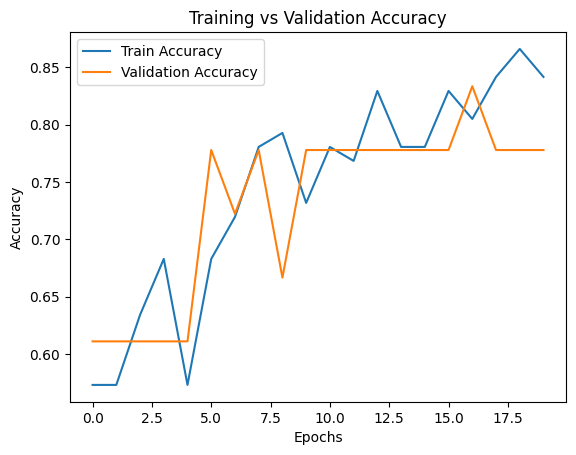

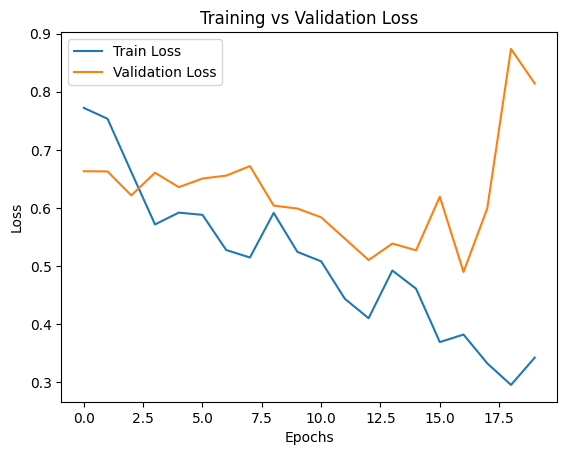

In [ ]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()

In [ ]:
model.save("/content/drive/MyDrive/Capstone Project/hybrid_3dcnn_vgg16_model.h5")
print("Model saved successfully")

Model saved successfully


In [ ]:
model.save("/content/drive/MyDrive/Capstone Project/hybrid_3dcnn_vgg16_model.keras")
print("Model saved in native Keras format")


Model saved in native Keras format
